In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve


In [2]:
# Load the dataset
df = pd.read_csv("emplyee_attrition.csv")

In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               59598 non-null  int64 
 1   Age                       59598 non-null  int64 
 2   Gender                    59598 non-null  object
 3   Years at Company          59598 non-null  int64 
 4   Job Role                  59598 non-null  object
 5   Monthly Income            59598 non-null  int64 
 6   Work-Life Balance         59598 non-null  object
 7   Job Satisfaction          59598 non-null  object
 8   Performance Rating        59598 non-null  object
 9   Number of Promotions      59598 non-null  int64 
 10  Overtime                  59598 non-null  object
 11  Distance from Home        59598 non-null  int64 
 12  Education Level           59598 non-null  object
 13  Marital Status            59598 non-null  object
 14  Number of Dependents  

In [4]:
# Drop unnecessary columns
if 'Employee ID' in df.columns:
    df.drop('Employee ID', axis=1, inplace=True)

In [5]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
# Split the dataset into features and target variable
X = df.drop(columns=['Attrition'])
y = df['Attrition']

In [7]:
y.value_counts()

Attrition
1    31260
0    28338
Name: count, dtype: int64

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
# param_grid for Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [10]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
# n_jobs=-1 uses all processors available
# verbose=1 shows the progress of the grid search

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [11]:
# get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Random Forest Classifier with the best hyperparameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predictions
y_pred = best_rf.predict(X_test)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [12]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7470637583892618
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73      5668
           1       0.75      0.77      0.76      6252

    accuracy                           0.75     11920
   macro avg       0.75      0.75      0.75     11920
weighted avg       0.75      0.75      0.75     11920

Confusion Matrix:
 [[4103 1565]
 [1450 4802]]


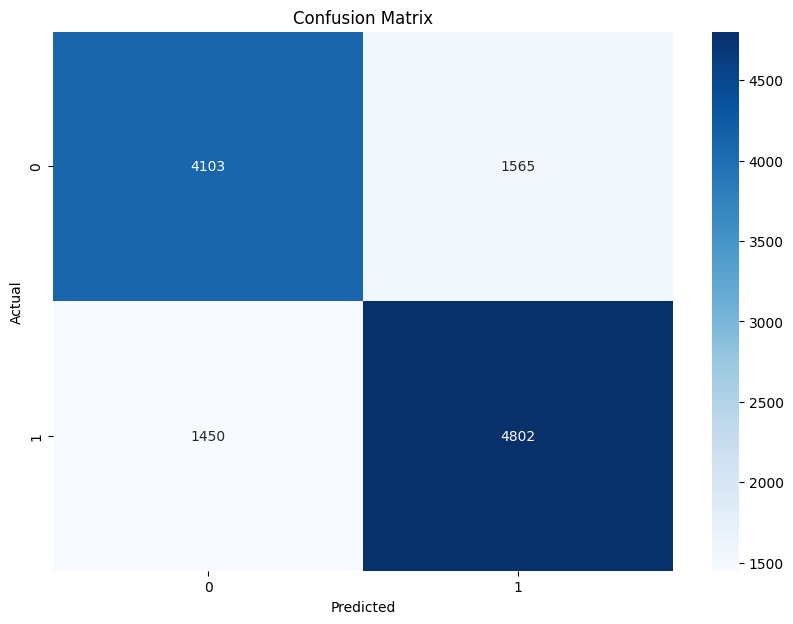

In [13]:
# Visualize of Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
# AUC-ROC Curve
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc)

AUC-ROC Score: 0.8351654640592641


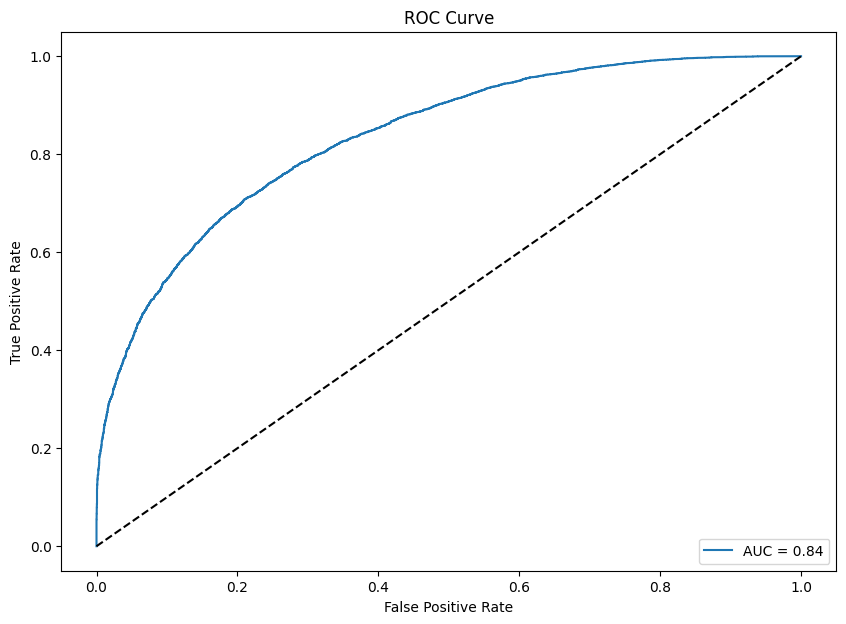

In [15]:
# Plot ROC Curve
fpr , tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='AUC = %.2f' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()